* Data cleaning by handling missing values and duplicates. It uses SimpleImputer to replace missing values with the most frequent values. After data cleaning, a heatmap is generated to visualize any remaining missing values, with the custom color palette applied for visualization. Donut chart and Bar charts are created based on certain features.

* Visualizing the distribution of numerical features using box plots. It then encodes categorical features and **applies TF-IDF and SVD on text-based** columns (pickup_zone, dropoff_zone). Finally, **it uses Power and Quantile transformations to normalize numerical features** and re-plots histograms to observe the distribution changes after transformation. This helps preprocess the data for machine learning models by improving feature distributions and handling categorical data effectively.

* The performance of three classifiers: LightGBM, CatBoost, and RandomForest. Each model is trained with a specific set of hyperparameters and evaluated using cross-validation with the ROC AUC metric. The results from each model's cross-validation are printed, allowing you to compare their average ROC AUC scores and assess their performance on the task of predicting payment type in the taxis dataset.

Importing the libraries

In [ ]:
!pip install colorama
!pip install catboost
!pip install lightgbm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from colorama import Fore, Style, init;
from scipy.stats import skew # importing the skew function

import plotly.graph_objects as go # Import Plotly.go

from plotly.subplots import make_subplots # Import subplots

from sklearn.model_selection import train_test_split #Model classifier
from  sklearn.impute import SimpleImputer # import Simple Imputer
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer # for TF -IDF transformation
from sklearn.decomposition import TruncatedSVD # import htis for dimensionality reduction

#Power Transformer
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *

#Palette
palette = ['#8DECB4','#41B06E','#FFF5E0']
color_palette = sns.color_palette(palette)

#remove warnings
import warnings
warnings.filterwarnings("ignore")

#setting the option to display all columns
pd.set_option('display.max_columns', None)

In [ ]:
taxis = sns.load_dataset('taxis')

In [ ]:
taxis.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


In [ ]:
taxis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6433 entries, 0 to 6432
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   pickup           6433 non-null   datetime64[ns]
 1   dropoff          6433 non-null   datetime64[ns]
 2   passengers       6433 non-null   int64         
 3   distance         6433 non-null   float64       
 4   fare             6433 non-null   float64       
 5   tip              6433 non-null   float64       
 6   tolls            6433 non-null   float64       
 7   total            6433 non-null   float64       
 8   color            6433 non-null   object        
 9   payment          6389 non-null   object        
 10  pickup_zone      6407 non-null   object        
 11  dropoff_zone     6388 non-null   object        
 12  pickup_borough   6407 non-null   object        
 13  dropoff_borough  6388 non-null   object        
dtypes: datetime64[ns](2), float64(5), int64(

In [ ]:
taxis.isnull().sum()

,0
pickup,0
dropoff,0
passengers,0
distance,0
fare,0
tip,0
tolls,0
total,0
color,0
payment,44


In [ ]:
taxis.duplicated().sum()

0

#Handling Null values  | Preprocessing

In [ ]:
taxis['dropoff_zone'].value_counts()

,count
dropoff_zone,
Upper East Side North,245
Murray Hill,220
Midtown Center,215
Upper East Side South,177
Midtown East,176
...,...
Bensonhurst East,1
Springfield Gardens South,1
East Flushing,1


In [ ]:
#data where dropoff_zone is null
taxis[taxis['dropoff_zone'].isnull()]

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
42,2019-03-30 23:59:14,2019-03-30 23:59:17,1,0.00,80.0,20.08,0.00,100.38,yellow,credit card,NaN,NaN,NaN,NaN
622,2019-03-12 19:52:36,2019-03-12 19:52:55,3,0.00,120.0,33.20,12.50,166.00,yellow,credit card,NaN,NaN,NaN,NaN
711,2019-03-21 17:39:50,2019-03-21 18:12:54,2,1.74,17.0,4.26,0.00,25.56,yellow,credit card,Midtown East,NaN,Manhattan,NaN
739,2019-03-14 00:09:17,2019-03-14 00:09:21,1,0.03,2.5,0.00,0.00,3.80,yellow,cash,Upper East Side South,NaN,Manhattan,NaN
970,2019-03-29 00:02:00,2019-03-29 00:02:05,2,0.00,45.0,5.00,0.00,50.30,yellow,credit card,NaN,NaN,NaN,NaN
1108,2019-03-10 09:33:13,2019-03-10 09:52:04,1,13.40,52.0,11.70,5.76,70.26,yellow,credit card,NaN,NaN,NaN,NaN
1112,2019-03-12 19:09:23,2019-03-12 19:20:46,1,0.90,8.5,1.92,0.00,14.72,yellow,credit card,Times Sq/Theatre District,NaN,Manhattan,NaN
1230,2019-03-29 07:52:46,2019-03-29 08:02:40,1,0.90,5.5,1.76,0.00,10.56,yellow,credit card,Yorkville East,NaN,Manhattan,NaN
1690,2019-03-22 06:24:14,2019-03-22 06:24:14,1,0.00,72.0,0.00,0.00,72.00,yellow,NaN,East New York,NaN,Brooklyn,NaN
1787,2019-03-28 06:58:57,2019-03-28 07:18:10,1,6.32,20.5,4.26,0.00,25.56,yellow,credit card,Manhattan Valley,NaN,Manhattan,NaN


- Columms with 45 missing values.
- when we see rows carefully, look at drop off zone and pick up zone are NaN and the distance for these rides is also 0.
Hence, dropping these rows from data

In [ ]:
# Missing Rows where both drop_off_zone and pick_up_zone values are Nan
missing_both_indices = taxis[(taxis['dropoff_zone'].isnull()) & (taxis['pickup_zone'].isnull())].index

#Dropping rows with missing values in both pickup and dropoff zones
taxis.drop(missing_both_indices, axis=0, inplace=True)

In [ ]:
#Data where dropoff_zone is null
taxis[taxis['dropoff_zone'].isnull()]

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
711,2019-03-21 17:39:50,2019-03-21 18:12:54,2,1.74,17.0,4.26,0.00,25.56,yellow,credit card,Midtown East,NaN,Manhattan,NaN
739,2019-03-14 00:09:17,2019-03-14 00:09:21,1,0.03,2.5,0.00,0.00,3.80,yellow,cash,Upper East Side South,NaN,Manhattan,NaN
1112,2019-03-12 19:09:23,2019-03-12 19:20:46,1,0.90,8.5,1.92,0.00,14.72,yellow,credit card,Times Sq/Theatre District,NaN,Manhattan,NaN
1230,2019-03-29 07:52:46,2019-03-29 08:02:40,1,0.90,5.5,1.76,0.00,10.56,yellow,credit card,Yorkville East,NaN,Manhattan,NaN
1690,2019-03-22 06:24:14,2019-03-22 06:24:14,1,0.00,72.0,0.00,0.00,72.00,yellow,NaN,East New York,NaN,Brooklyn,NaN
1787,2019-03-28 06:58:57,2019-03-28 07:18:10,1,6.32,20.5,4.26,0.00,25.56,yellow,credit card,Manhattan Valley,NaN,Manhattan,NaN
2089,2019-03-12 16:21:28,2019-03-12 16:43:40,1,5.69,21.0,0.00,0.00,22.80,yellow,cash,JFK Airport,NaN,Queens,NaN
2180,2019-03-09 15:00:06,2019-03-09 15:50:29,2,14.82,50.5,0.00,2.64,53.94,yellow,credit card,Flatiron,NaN,Manhattan,NaN
2231,2019-03-11 10:17:31,2019-03-11 11:03:55,1,26.35,130.0,0.00,5.76,136.56,yellow,cash,East Harlem North,NaN,Manhattan,NaN
2402,2019-03-29 22:29:40,2019-03-29 22:54:28,3,19.20,84.0,0.00,0.00,85.30,yellow,cash,JFK Airport,NaN,Queens,NaN


In [ ]:
# Missing rows where both pickup and dropoff zones are NaN and distance is also 0.

missing_both_indices_distances = taxis[(taxis['dropoff_zone'].isnull()) & (taxis['pickup_zone'].isnull()) & (taxis['distance']==0.00)].index

#Dropping rows with missing values
taxis.drop(missing_both_indices_distances, axis=0, inplace =True)


In [ ]:
#Data where dropoff_zone is NaN
taxis[taxis['dropoff_zone'].isnull()]

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
711,2019-03-21 17:39:50,2019-03-21 18:12:54,2,1.74,17.0,4.26,0.00,25.56,yellow,credit card,Midtown East,NaN,Manhattan,NaN
739,2019-03-14 00:09:17,2019-03-14 00:09:21,1,0.03,2.5,0.00,0.00,3.80,yellow,cash,Upper East Side South,NaN,Manhattan,NaN
1112,2019-03-12 19:09:23,2019-03-12 19:20:46,1,0.90,8.5,1.92,0.00,14.72,yellow,credit card,Times Sq/Theatre District,NaN,Manhattan,NaN
1230,2019-03-29 07:52:46,2019-03-29 08:02:40,1,0.90,5.5,1.76,0.00,10.56,yellow,credit card,Yorkville East,NaN,Manhattan,NaN
1690,2019-03-22 06:24:14,2019-03-22 06:24:14,1,0.00,72.0,0.00,0.00,72.00,yellow,NaN,East New York,NaN,Brooklyn,NaN
1787,2019-03-28 06:58:57,2019-03-28 07:18:10,1,6.32,20.5,4.26,0.00,25.56,yellow,credit card,Manhattan Valley,NaN,Manhattan,NaN
2089,2019-03-12 16:21:28,2019-03-12 16:43:40,1,5.69,21.0,0.00,0.00,22.80,yellow,cash,JFK Airport,NaN,Queens,NaN
2180,2019-03-09 15:00:06,2019-03-09 15:50:29,2,14.82,50.5,0.00,2.64,53.94,yellow,credit card,Flatiron,NaN,Manhattan,NaN
2231,2019-03-11 10:17:31,2019-03-11 11:03:55,1,26.35,130.0,0.00,5.76,136.56,yellow,cash,East Harlem North,NaN,Manhattan,NaN
2402,2019-03-29 22:29:40,2019-03-29 22:54:28,3,19.20,84.0,0.00,0.00,85.30,yellow,cash,JFK Airport,NaN,Queens,NaN


Let's Impute these values with the help of **Simple Imputer**

In [ ]:
#intialize imputer
imputer = SimpleImputer(strategy='most_frequent')

#Fit and transform
taxis[['dropoff_zone']]=imputer.fit_transform(taxis[['dropoff_zone']].values.reshape(-1,1))


In [ ]:
#Double checking to see if issingvalues present in dropoff_zone
taxis['dropoff_zone'].isnull().sum()

0

# **Dropoff_borough**

In [ ]:
taxis['dropoff_borough'].value_counts()

,count
dropoff_borough,
Manhattan,5206
Queens,542
Brooklyn,501
Bronx,137
Staten Island,2


In [ ]:
#values where dropoff_borough is null
taxis[taxis['dropoff_borough'].isnull()]



,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
711,2019-03-21 17:39:50,2019-03-21 18:12:54,2,1.74,17.0,4.26,0.00,25.56,yellow,credit card,Midtown East,Upper East Side North,Manhattan,NaN
739,2019-03-14 00:09:17,2019-03-14 00:09:21,1,0.03,2.5,0.00,0.00,3.80,yellow,cash,Upper East Side South,Upper East Side North,Manhattan,NaN
1112,2019-03-12 19:09:23,2019-03-12 19:20:46,1,0.90,8.5,1.92,0.00,14.72,yellow,credit card,Times Sq/Theatre District,Upper East Side North,Manhattan,NaN
1230,2019-03-29 07:52:46,2019-03-29 08:02:40,1,0.90,5.5,1.76,0.00,10.56,yellow,credit card,Yorkville East,Upper East Side North,Manhattan,NaN
1690,2019-03-22 06:24:14,2019-03-22 06:24:14,1,0.00,72.0,0.00,0.00,72.00,yellow,NaN,East New York,Upper East Side North,Brooklyn,NaN
1787,2019-03-28 06:58:57,2019-03-28 07:18:10,1,6.32,20.5,4.26,0.00,25.56,yellow,credit card,Manhattan Valley,Upper East Side North,Manhattan,NaN
2089,2019-03-12 16:21:28,2019-03-12 16:43:40,1,5.69,21.0,0.00,0.00,22.80,yellow,cash,JFK Airport,Upper East Side North,Queens,NaN
2180,2019-03-09 15:00:06,2019-03-09 15:50:29,2,14.82,50.5,0.00,2.64,53.94,yellow,credit card,Flatiron,Upper East Side North,Manhattan,NaN
2231,2019-03-11 10:17:31,2019-03-11 11:03:55,1,26.35,130.0,0.00,5.76,136.56,yellow,cash,East Harlem North,Upper East Side North,Manhattan,NaN
2402,2019-03-29 22:29:40,2019-03-29 22:54:28,3,19.20,84.0,0.00,0.00,85.30,yellow,cash,JFK Airport,Upper East Side North,Queens,NaN


In [ ]:
taxis['dropoff_borough'].isnull().sum()

24

Here, again we impute the values of dropoff_borough with most frequent value


In [ ]:
imputer = SimpleImputer(strategy="most_frequent")

taxis[['dropoff_borough']]=imputer.fit_transform(taxis[['dropoff_borough']].values.reshape(-1,1))


In [ ]:
#double checking for missing values

taxis['dropoff_borough'].isnull().sum()

0

**PICKUP ZONE**

In [ ]:
taxis['pickup_zone'].value_counts()

,count
pickup_zone,
Midtown Center,230
Upper East Side South,211
Penn Station/Madison Sq West,210
Clinton East,208
Midtown East,198
...,...
Homecrest,1
Bedford Park,1
Riverdale/North Riverdale/Fieldston,1


In [ ]:
taxis[taxis['pickup_zone'].isnull()]

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
606,2019-03-19 15:04:40,2019-03-19 15:06:15,1,0.40,3.5,1.35,0.00,8.15,yellow,credit card,NaN,Upper East Side South,NaN,Manhattan
671,2019-03-09 22:45:46,2019-03-09 22:46:50,1,0.40,3.5,0.00,0.00,7.30,yellow,cash,NaN,Lincoln Square East,NaN,Manhattan
712,2019-03-03 01:24:45,2019-03-03 01:29:32,1,0.80,5.0,1.75,0.00,10.55,yellow,credit card,NaN,West Chelsea/Hudson Yards,NaN,Manhattan
1961,2019-03-19 16:43:59,2019-03-19 17:37:22,1,17.82,52.0,13.11,5.76,78.67,yellow,credit card,NaN,Garment District,NaN,Manhattan
3793,2019-03-24 06:07:30,2019-03-24 06:12:22,1,1.50,6.5,0.00,0.00,9.80,yellow,NaN,NaN,Midtown East,NaN,Manhattan


Again we use SimpleImputer to impute it with most frequent value

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')

taxis[['pickup_zone']]=imputer.fit_transform(taxis[['pickup_zone']].values.reshape(-1,1))

In [ ]:
taxis['pickup_zone'].isnull().sum()

0

**PICKUP_BOROUGH**

In [ ]:
taxis[['pickup_borough']].value_counts()

,count
pickup_borough,
Manhattan,5268
Queens,657
Brooklyn,383
Bronx,99


In [ ]:
taxis[taxis['pickup_borough'].isnull()]

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
606,2019-03-19 15:04:40,2019-03-19 15:06:15,1,0.40,3.5,1.35,0.00,8.15,yellow,credit card,Midtown Center,Upper East Side South,NaN,Manhattan
671,2019-03-09 22:45:46,2019-03-09 22:46:50,1,0.40,3.5,0.00,0.00,7.30,yellow,cash,Midtown Center,Lincoln Square East,NaN,Manhattan
712,2019-03-03 01:24:45,2019-03-03 01:29:32,1,0.80,5.0,1.75,0.00,10.55,yellow,credit card,Midtown Center,West Chelsea/Hudson Yards,NaN,Manhattan
1961,2019-03-19 16:43:59,2019-03-19 17:37:22,1,17.82,52.0,13.11,5.76,78.67,yellow,credit card,Midtown Center,Garment District,NaN,Manhattan
3793,2019-03-24 06:07:30,2019-03-24 06:12:22,1,1.50,6.5,0.00,0.00,9.80,yellow,NaN,Midtown Center,Midtown East,NaN,Manhattan


In [ ]:
imputer = SimpleImputer(strategy = 'most_frequent')

taxis[['pickup_borough']]=imputer.fit_transform(taxis[['pickup_borough']].values.reshape(-1,1))

In [ ]:
taxis['pickup_borough'].isnull().sum()

0

**PAYMENT**

In [ ]:
taxis['payment'].value_counts()

,count
payment,
credit card,4560
cash,1808


In [ ]:
taxis[taxis['payment'].isnull()]

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
7,2019-03-22 12:47:13,2019-03-22 12:58:17,0,1.4,8.5,0.0,0.00,11.80,yellow,NaN,Murray Hill,Flatiron,Manhattan,Manhattan
445,2019-03-19 06:57:14,2019-03-19 07:00:08,1,1.3,5.5,0.0,0.00,6.30,yellow,NaN,Boerum Hill,Columbia Street,Brooklyn,Brooklyn
491,2019-03-07 07:11:33,2019-03-07 07:11:39,1,1.6,2.5,0.0,0.00,5.80,yellow,NaN,Murray Hill,Murray Hill,Manhattan,Manhattan
545,2019-03-27 11:03:43,2019-03-27 11:14:34,1,4.2,15.0,0.0,0.00,15.80,yellow,NaN,LaGuardia Airport,Forest Hills,Queens,Queens
621,2019-03-15 17:16:35,2019-03-15 17:25:01,1,1.3,7.5,0.0,0.00,11.80,yellow,NaN,Upper East Side North,Upper East Side South,Manhattan,Manhattan
770,2019-03-02 03:16:59,2019-03-02 03:17:06,0,9.4,2.5,0.0,0.00,3.80,yellow,NaN,JFK Airport,JFK Airport,Queens,Queens
913,2019-03-23 11:26:58,2019-03-23 11:35:17,2,1.3,7.5,0.0,0.00,10.80,yellow,NaN,Upper East Side South,Lincoln Square West,Manhattan,Manhattan
953,2019-03-08 02:58:37,2019-03-08 03:19:27,2,6.9,23.5,0.0,0.00,27.30,yellow,NaN,Garment District,Central Harlem North,Manhattan,Manhattan
1207,2019-03-08 15:41:20,2019-03-08 15:41:23,1,0.0,2.5,0.0,0.00,5.80,yellow,NaN,Hudson Sq,Hudson Sq,Manhattan,Manhattan
1372,2019-03-12 09:19:44,2019-03-12 09:43:09,1,1.6,14.5,0.0,0.00,17.80,yellow,NaN,Midtown East,Garment District,Manhattan,Manhattan


In [ ]:
taxis['payment'].isnull().sum()

44

Here, we remove the rows where payment and distance is NaN

In [ ]:
missing_payment_Distance = taxis[(taxis['payment'].isnull()) & (taxis['distance']==0.00)].index

print(missing_payment_Distance)

taxis.drop(missing_payment_Distance, axis=0, inplace=True)

Index([1207, 1690, 1929, 3109, 4955], dtype='int64')


In [ ]:
taxis[taxis['payment'].isnull()]

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
7,2019-03-22 12:47:13,2019-03-22 12:58:17,0,1.4,8.5,0.0,0.00,11.80,yellow,NaN,Murray Hill,Flatiron,Manhattan,Manhattan
445,2019-03-19 06:57:14,2019-03-19 07:00:08,1,1.3,5.5,0.0,0.00,6.30,yellow,NaN,Boerum Hill,Columbia Street,Brooklyn,Brooklyn
491,2019-03-07 07:11:33,2019-03-07 07:11:39,1,1.6,2.5,0.0,0.00,5.80,yellow,NaN,Murray Hill,Murray Hill,Manhattan,Manhattan
545,2019-03-27 11:03:43,2019-03-27 11:14:34,1,4.2,15.0,0.0,0.00,15.80,yellow,NaN,LaGuardia Airport,Forest Hills,Queens,Queens
621,2019-03-15 17:16:35,2019-03-15 17:25:01,1,1.3,7.5,0.0,0.00,11.80,yellow,NaN,Upper East Side North,Upper East Side South,Manhattan,Manhattan
770,2019-03-02 03:16:59,2019-03-02 03:17:06,0,9.4,2.5,0.0,0.00,3.80,yellow,NaN,JFK Airport,JFK Airport,Queens,Queens
913,2019-03-23 11:26:58,2019-03-23 11:35:17,2,1.3,7.5,0.0,0.00,10.80,yellow,NaN,Upper East Side South,Lincoln Square West,Manhattan,Manhattan
953,2019-03-08 02:58:37,2019-03-08 03:19:27,2,6.9,23.5,0.0,0.00,27.30,yellow,NaN,Garment District,Central Harlem North,Manhattan,Manhattan
1372,2019-03-12 09:19:44,2019-03-12 09:43:09,1,1.6,14.5,0.0,0.00,17.80,yellow,NaN,Midtown East,Garment District,Manhattan,Manhattan
1566,2019-03-18 02:20:59,2019-03-18 02:49:24,1,6.0,23.0,0.0,0.00,26.80,yellow,NaN,TriBeCa/Civic Center,Bushwick South,Manhattan,Brooklyn


In [ ]:
taxis['payment'].isnull().sum()

39

In [ ]:
#using SimpleImputer to impute the missing values

imputer = SimpleImputer(strategy="most_frequent")

taxis[['payment']]=imputer.fit_transform(taxis[['payment']].values.reshape(-1,1))

In [ ]:
taxis['payment'].isnull().sum()

0

**We have successfully handled missing values**

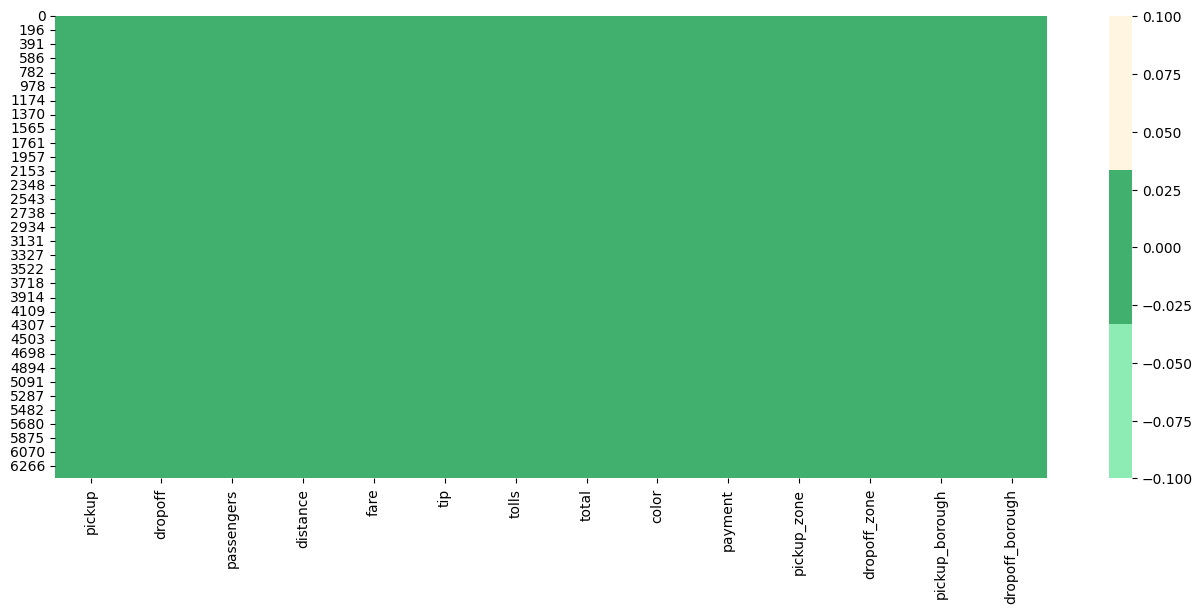

In [ ]:
#Plot the heatmap with custom color palatte

plt.figure(figsize=(16, 6))
sns.heatmap(taxis.isnull(), cmap=palette)
plt.show()

# **EDA Analysis**

In [ ]:
## Function to plot single Pie and Bar plot
def single_plot_distribution(column_name, dataframe):
  value_counts=dataframe[column_name].value_counts()

 # Set up the figure with two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1]})

 # Donut pie chart
  pie_colors = palette[0:3]
  ax1.pie(value_counts, autopct='%0.00001f%%', startangle=90, pctdistance=0.85, colors=pie_colors, labels=None)
  centre_circle = plt.Circle((0,0),0.65,fc='white')
  ax1.add_artist(centre_circle)
  ax1.set_title(f'Distribution of {column_name}', fontsize=17)

# ax1.pie(...): Draws the pie chart with slices colored by pie_colors.
# autopct='%0.00001f%%': Displays the percentage of each slice to five decimal places.
# startangle=90: Starts the first slice at the top (90 degrees).
# pctdistance=0.85: Adjusts how far the percentage labels are from the center.
# centre_circle: Adds a white circle in the middle to create the "donut" effect.
# ax1.set_title(...): Sets the title of the pie chart


  # Bar chart
  bar_colors = palette[0:3]
  sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax2, palette=bar_colors,)
  ax2.set_title(f'Count of {column_name}', fontsize=17)
  ax2.set_xlabel(column_name, fontsize=16)
  ax2.set_ylabel('Count', fontsize=16)

  # Rotate x-axis labels for better readability
  ax2.tick_params(axis='x', rotation=90)

  # Show the plots
  plt.tight_layout()
  plt.show()



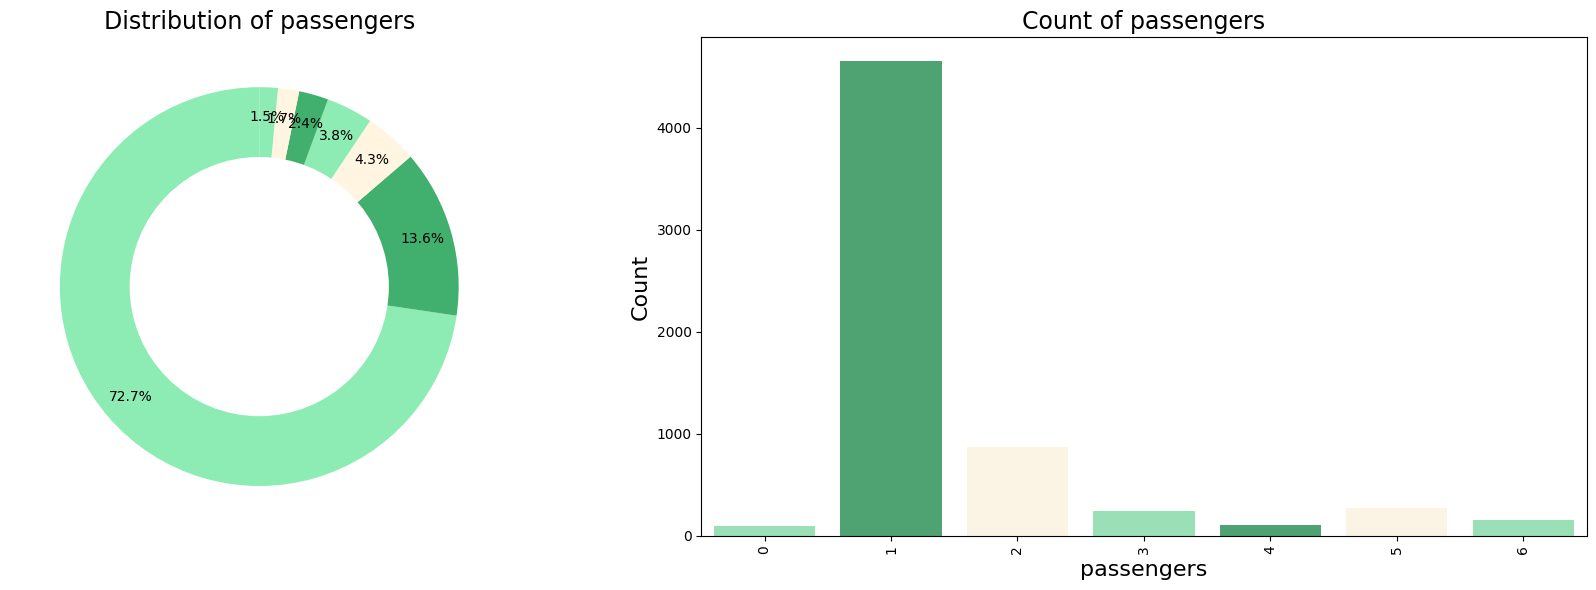

In [ ]:
#Passenger distribution
single_plot_distribution('passengers', taxis)

Observations:
- **Most common passenger count:**
is found to be 1 with 4653 occurences. meaning ***that taxis often transport single passengers.***
- **Distribution of passenger count:** majority of taxi rides have fewer passengers, with counts decreasing as the number of passengers increases.
- **Single passenger trips**: are more frequent compared to trips with multiple passengers.
- **Group travel**: there are still significant no of rides with 2 passengers followed by smaller numbers for 3,4,5 and 6 passengers. This indicates that taxis are also used for small group travel although less frequently than single passenger trips.
- **Zero passengers:** Found 96 instances where passenger count was 0, this could be due to courier rides and we cannot take these values as outliers.

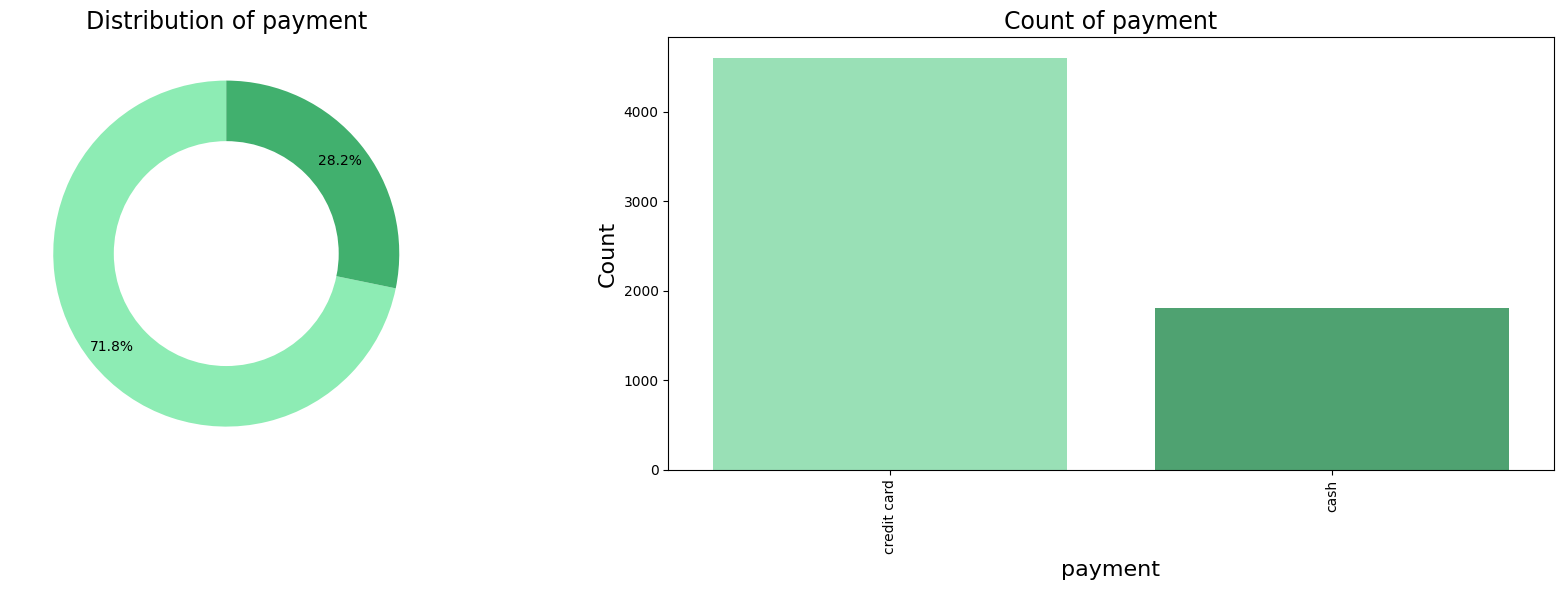

In [ ]:
#pie plot to show count of payment
single_plot_distribution('payment',taxis)

Observations:

- **Credit card payment**: Majority of passengers ( 4598 instances) have used/preferred this mode of payment. This also suggests that having this mode of payment is essential for serving this significant portion of customers.
It also implies that integrating credit card machines into taxis can also lead to increase in business opportunities and customer satisfaction.

- **Cash payment**: This mode is less preferred compared to credit card payment with onlly 1806 instances recorded.

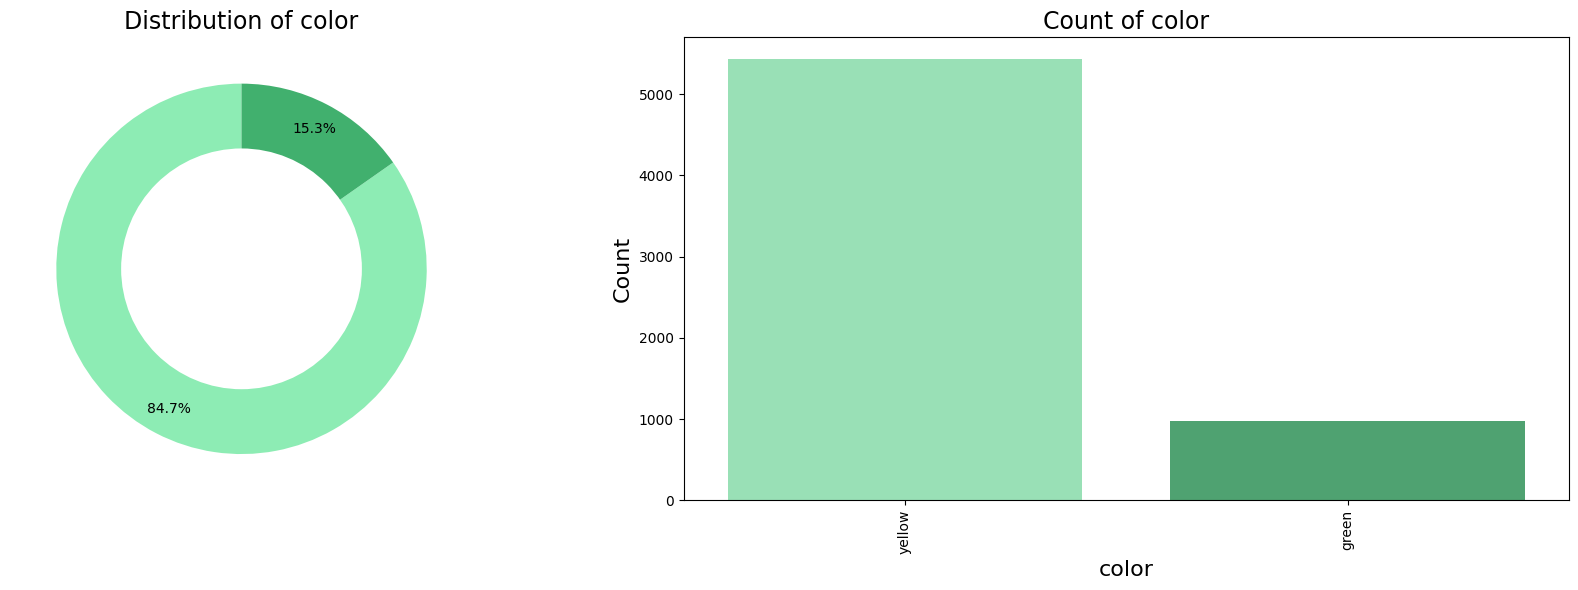

In [ ]:
#Pie plot to show count of payment
single_plot_distribution('color', taxis)

Observations:

- **Yellow Taxi**: are more preferred by customers compared to green ones with 5429 rides recorded.
- **Green Taxi**: although less preferred but it does represent a substantial portion of dataset i.e 975 rides recorded.

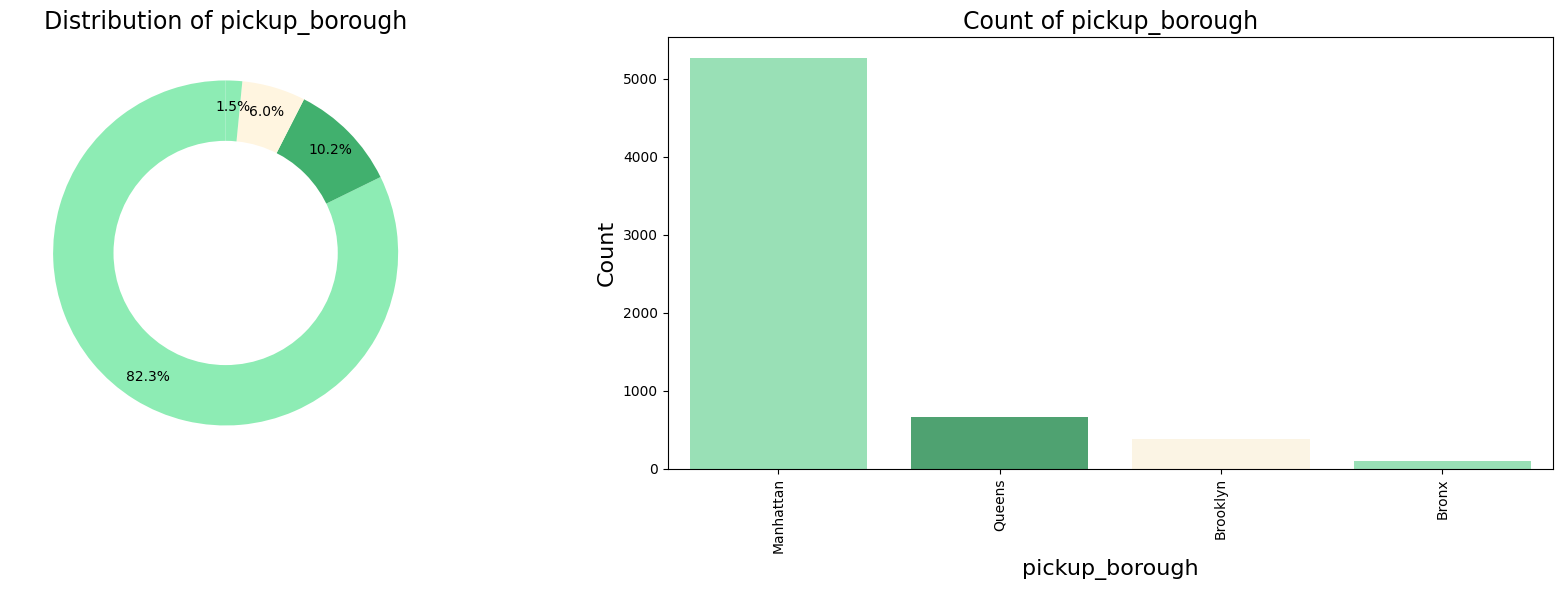

In [ ]:
#pickup_borough Distribution
single_plot_distribution('pickup_borough', taxis)

Observations:

- **Manhattan** : Highest number of pickups compared to other boroughs with 5270 pickups. This could be because of high population density, commercial activities, Manhattan is major hub for taxi services.
- **Queens & Brooklyn**: Queens with 655 and Brooklyn with 380 pickups have far lower demand compared to Manhattan, suggesting lower demand of taxi services in these ares.
- **Bronx**: Lowest number of pickups having only 99 pickups. This might be due to lower population density or lesser commercial activity.

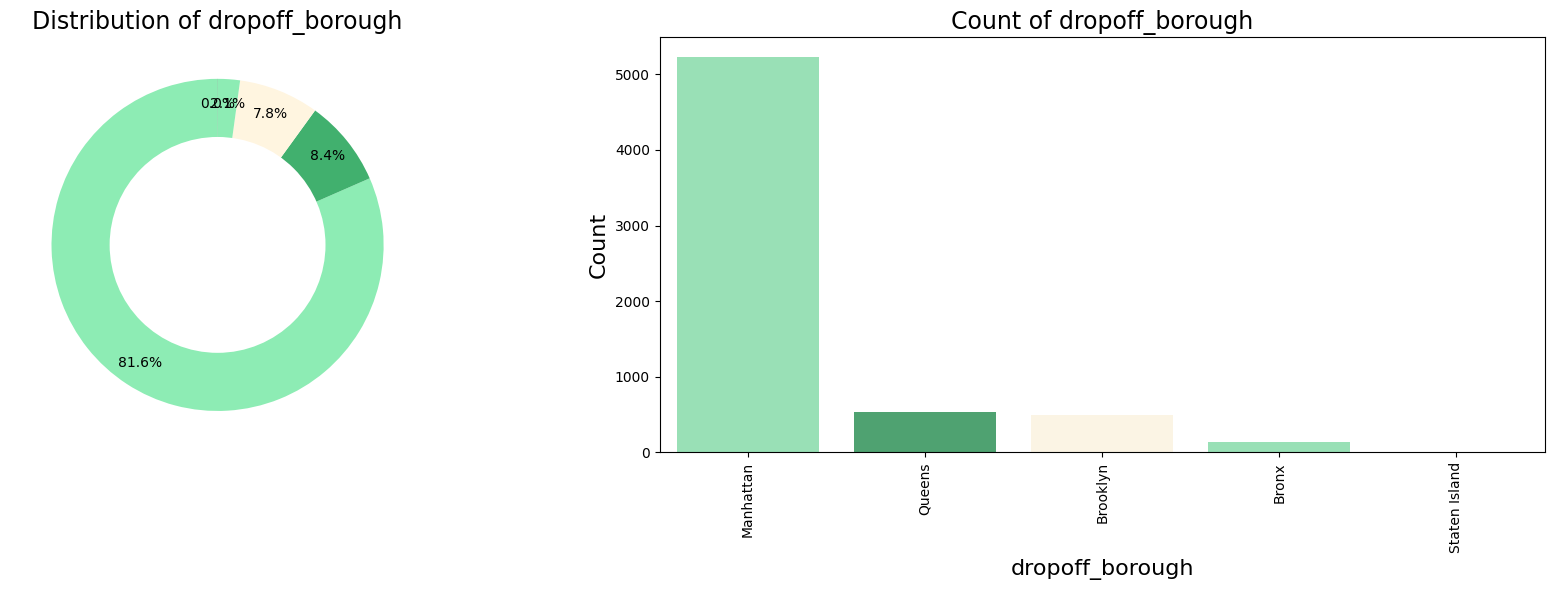

In [ ]:
#drop_off borough distribution
single_plot_distribution('dropoff_borough',taxis)

Observations:

- Manhattan: It appers to be most common & highest drop off borough compared to others. Probably because Manhattan being a major commercial, cultural and tourist hub, substantial portion of taxi rides culminates in Manhattan.
- Queens & Brooklyn: Less common than Manhattan, but indicates that taxi services are being used across different areas of city for commuting, leisure or errands.
- Bronx & Staten Island: Lowest drop off counts  compared to other borough. Staten Island's notably low count may be due to its geographical location from rest of city and lower population density.

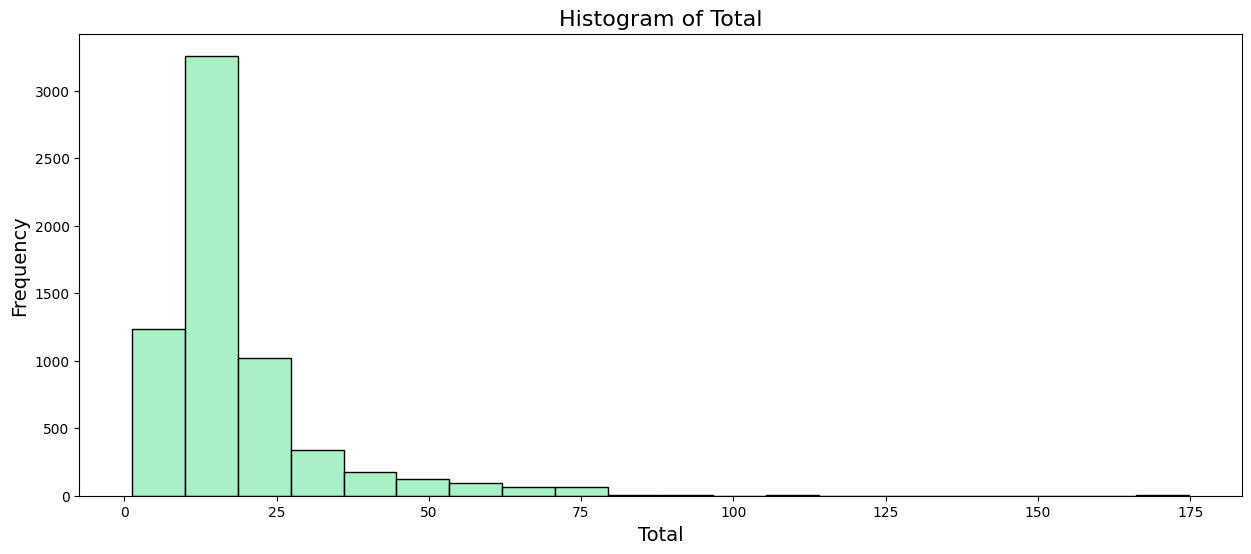

In [ ]:
# Total Histogram
# Define your custom color palette
custom_palette = ['#8DECB4', '#41B06E', '#FFF5E0']

# Create the histogram using Seaborn
plt.figure(figsize=(15, 6))
sns.histplot(data=taxis, x='total', bins=20, color=custom_palette[0])

# Set the labels and title
plt.xlabel('Total', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of Total', fontsize=16)

# Show the plot
plt.show()

**Does Fare depend on Tips? Making a scatter plot to observe this**

In [ ]:
#Tips  Vs Fare

# Define your custom color palette
custom_palette = ['#41B06E', '#FFF5E0']

# Create the scatter plot using Plotly Express
fig = px.scatter(taxis, x='fare', y='tip', title='Fare vs Tip Scatter Plot', color_discrete_sequence=custom_palette)

# Update the layout
fig.update_layout(
    xaxis_title='Fare',
    yaxis_title='Tip',
    title_font_size=20
)

# Show the plot
fig.show()

Observations:

- **Highest tip** recorded in this dataset is 23.19\$ for the fare 75.5\$ which is not the highest fare.
- **Lowest tip **recorded was 0\$ which is coinciding with lowest fare of 1\$.

- After examining the plot, a very discernible **positive correlation** is observed between tip and fare. Generally as the fare imcreases tip increases. **However, it is notable that certain rides exhibiting a high fare yielded in no tip.**

**Does Total_bill & Tips have any relation?**

In [ ]:
# Tips Vs Total_bill | Make a Scatter Plot to Observe This

# Define your custom color palette
custom_palette = ['#41B06E', '#FFF5E0']

# Create the scatter plot using Plotly Express
fig = px.scatter(taxis, x='total', y='tip', title='Total vs Tip Scatter Plot', color_discrete_sequence=custom_palette)

# Update the layout
fig.update_layout(
    xaxis_title='Fare',
    yaxis_title='Tip',
    title_font_size=20
)

# Show the plot
fig.show()

Observations:

- **Highest tip** recorded was 23.19\$ and highest fare recorded was 174.82\$.
- **Lowest tip** observed was 0\$ coinciding with lowest fare i.e 1.3\$
- There seems to be a discernible positive correlation between tip amount and total bill.

**Does Total bill and Distance have relation?**

In [ ]:
 # Distance  Vs Total_bill  | Make a scatter plot to observe this

# Define your custom color palette
custom_palette = ['#41B06E', '#FFF5E0']

# Create the scatter plot using Plotly Express
fig = px.scatter(taxis, x='total', y='distance', title='Total vs Distance Scatter Plot', color_discrete_sequence=custom_palette)

# Update the layout
fig.update_layout(
    xaxis_title='Fare',
    yaxis_title='Tip',
    title_font_size=20
)

# Show the plot
fig.show()

Observations:

- Longest distance with highest total: was recored to be 36.7 km with total of 174.82\$.
- Shortest distance with lowest total: was recorded to be 0km coinciding with lowest total of $1.3\$. Can consider this as an outlier.
- There isa positive correlation between Distance and Total. As the distance increases, so does the total.

Some of the rides showed 0 distance and yet high fare indicating as outliers, and have to be removed. This is done in Outlier section

**Does Total_bill and Passenger have relation between them?**

In [ ]:
# Passenger  Vs Total_bill

# Create the scatter plot using Plotly Express
fig = px.scatter(taxis, x='passengers', y='total', title='Total vs Passenger Scatter Plot', color_discrete_sequence=custom_palette)

# Update the layout
fig.update_layout(
    xaxis_title='Fare',
    yaxis_title='Tip',
    title_font_size=20
)

# Show the plot
fig.show()


Observations:

- 1 passenger: Rides with 1 passenger tend to have higher avg total compared to other number of passenger.
- 2 passengers: exhibited a higher total fare with highest total of 174.82\$.
- 0 passenger: This could represent courier service. These cannot be considered as outliers, they also tend to have lower avg prices.

**Does Payment and Total bill habe relation between them?**

In [ ]:
# Create the scatter plot using Plotly Express
fig = px.scatter(taxis, x='payment', y='total', title='Total vs Payment Scatter Plot', color_discrete_sequence=custom_palette)

# Update the layout
fig.update_layout(
    xaxis_title='Fare',
    yaxis_title='Tip',
    title_font_size=20
)

# Show the plot
fig.show()

Observations:

- Highest Total amount i.e 174.82\$ was paid through Cash.
- Lowest Total amount i.e 1.3\$ was again paid through Cash.


#PAIR PLOT

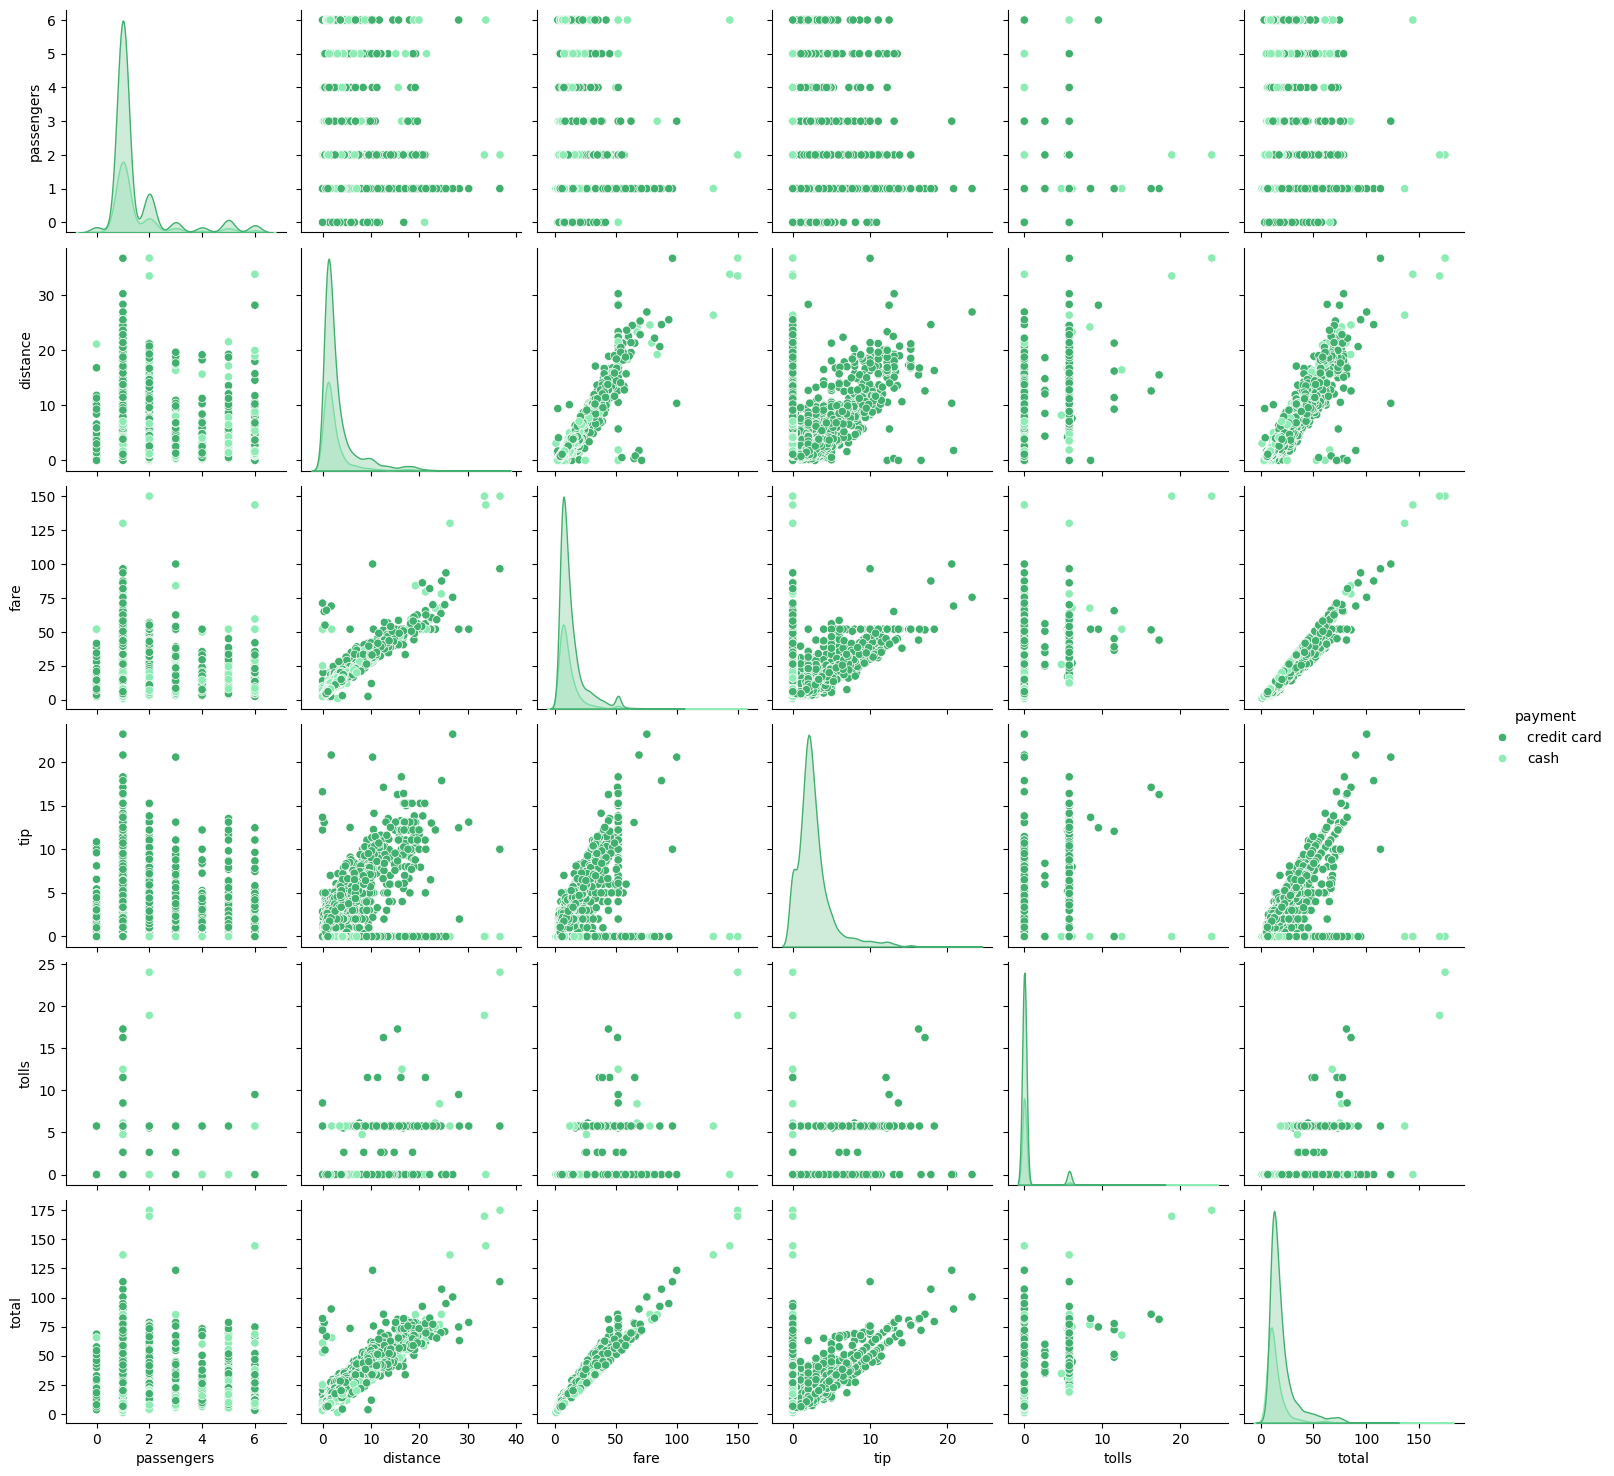

In [ ]:
# Define your custom color palette
custom_palette = ['#8DECB4', '#41B06E', '#FFF5E0']

# Columns for pair plot
columns_to_plot = ['pickup', 'dropoff', 'passengers', 'distance', 'fare', 'tip', 'tolls', 'total','payment']

# Data Columns
data_to_plot = taxis[columns_to_plot]

# Create a dictionary to map colors to unique values of the 'Quality' column
Q_colors = {'credit card' : palette[1], 'cash' : palette[0], 'other': 'gray'}

# Creating the pairplot with the specified palette for categorical variables
sns.pairplot(data_to_plot, hue='payment', palette=Q_colors)
plt.show()

#**Outlier Analysis**

In [ ]:
taxis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6407 entries, 0 to 6432
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   pickup           6407 non-null   datetime64[ns]
 1   dropoff          6407 non-null   datetime64[ns]
 2   passengers       6407 non-null   int64         
 3   distance         6407 non-null   float64       
 4   fare             6407 non-null   float64       
 5   tip              6407 non-null   float64       
 6   tolls            6407 non-null   float64       
 7   total            6407 non-null   float64       
 8   color            6407 non-null   object        
 9   payment          6407 non-null   object        
 10  pickup_zone      6407 non-null   object        
 11  dropoff_zone     6407 non-null   object        
 12  pickup_borough   6407 non-null   object        
 13  dropoff_borough  6407 non-null   object        
dtypes: datetime64[ns](2), float64(5), int64(1), o

In [ ]:
# Numerical cols
numerical_cols = [col for col in taxis.columns if taxis[col].dtype in ['int64','float64']]

#creating subplots with 2 rows and 3 columns
fig = make_subplots(rows=2, cols=3, subplot_titles=numerical_cols)

#Looping through each row of subplot
for i in range(2):
  #looping through each subplot in row
  for j in range(3):
    #calculate the index of current numerical column
    index = i * 3 + j
    #checking if the index is within th range of available numerical columns
    if index < len(numerical_cols):
      #add a boxplot for current numerical column to the subplot
      fig.add_trace(go.Box(x=taxis[numerical_cols[index]], name=numerical_cols[index],marker_color=palette[index % len(palette)]), row=i+1, col=j+1)


#Update layout
fig.update_layout(height=600, width=1000, title_text="Box plot of Numerical columns")

fig.show()


# go.Box: Creates a box plot.
# x=taxis[numerical_cols[index]]: Uses the data from the current numerical column.
# name=numerical_cols[index]: Labels the box plot with the column name.
# marker_color=palette[index % len(palette)]: Sets the color of the plot, cycling through your color palette.
# row=i + 1, col=j + 1: Places the plot in the correct row and column of your grid.

# Row 1, Column 1 (i=0, j=0): Plots a box plot for passengers.
# Row 1, Column 2 (i=0, j=1): Plots a box plot for distance.
# Row 1, Column 3 (i=0, j=2): Plots a box plot for fare.
# Row 2, Column 1 (i=1, j=0): Plots a box plot for tip.
# Row 2, Column 2 (i=1, j=1): Plots a box plot for tolls.
# Row 2, Column 3 (i=1, j=2): Plots a box plot for total.



Observations:

- 1) Passengers: Lower fence of passenger count is 0, indicating that some rides have no passenger (used for courier purposes). Passenger counts of 4,5,6 are identified as outliers in dataset.
- 2) Distance: The lower distance is 0 which is an outlier. Most rides fall in the range 1km to 7.2km.
- 3) Fare: Lowest fare is 1\$ and upper fare is 150\$. Avg fare ranges between 1\$ to 27\$. While some rides have higher fares due to weather conditions or longer distances, these outliers offer valuable insights.
- 4) Tip: Lowest tip offered was 0\$, meaning some passengers paid only the fare amount without additional tip. This should not be treated as an outlier. However, there are instances of higher tip amounts influenced by factors like wealthy passengers or exceptional serive provided bt driver. This cannot be considered as an outlier.
- 5) Tolls: ranges from €1.65 to €12 for cars in Europe. Values outside this range can be considered as outliers.
- 6) Total: The lower fence of total amount is 1.3 and the upper value is 174.82. Avg total fare ranges between 1.3 and 34.42. However, some rides had higher total amounts due to factors like weather condition, longer distances or larger tip. These cannot be considered as outliers.


**Overall, Outliers may intially appear as anomalies, they often offer valuable insights into underlying patterns and behaviours. Therefore, it is important to exercise caution when removing the from dataset.**

#ENCODING

- First, we will encode the variables with low classes with **Label Encoder.**
- Secondly, we will convert Textual data to categorical by using **TFIDF, BOW method.**

Label Encoding

In [ ]:
categorical_cols = [col for col in taxis.columns if taxis[col].dtype == 'object']

#Intialize
le = LabelEncoder()

#cols to encode
cols_low_classes = ['color','payment','pickup_borough','dropoff_borough']

#encoding
for col in cols_low_classes:
  #fit and transform
  taxis[col]= le.fit_transform(taxis[col])

TF_IDF Vectorization

In [ ]:
#Intialize Tfidf Vectorizer with maximu 1000 features
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

#Transform the text data in specified column of training dataframe
vectors_train = vectorizer.fit_transform(taxis['pickup_zone'])

#Dimensionality reduction using SVD (Singular Value Decomposition)
svd = TruncatedSVD(5) #Intialize TruncatedSVD with 3 components
x_sv_train = svd.fit_transform(vectors_train) #Fit and transform the TF-IDF vectors using SVD.

#convert the transformed features into DataFrame
tfidf_df_train = pd.DataFrame(x_sv_train)

#Naming columns in New DataFrame
cols = [('pickup_zone' + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
tfidf_df_train.columns = cols

#resetting the index of DataFrame before concatenation
taxis = taxis.reset_index(drop=True)

#Concatenate transformed features with original training data
taxis = pd.concat([taxis, tfidf_df_train], axis="columns")

# Convert pickup_zone from text to numerical vectors using TF-IDF.
# Reduce the size of these vectors using SVD to make the data easier to handle.
# Convert the reduced vectors into a DataFrame.
# Combine the new DataFrame with the original taxis dataset to have both the original and transformed data



In [ ]:

################### similar steps performed for dropoff_zone column

# Intialize the Tfidf vectorizer with max 1000 features
vectorizer = TfidfVectorizer(max_features = 1000, stop_words = 'english')

#Transform the text data in specified column of training dataframe
vectors_train = vectorizer.fit_transform(taxis['dropoff_zone'])

#Dimensionality reduction using SVD
svd = TruncatedSVD(5)
x_sv_train = svd.fit_transform(vectors_train)

#convert the transformed features into DataFrame
tfidf_df_train = pd.DataFrame(x_sv_train)

#Naming cols in new dataframe
cols = [('dropoff_zone' + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
tfidf_df_train.columns = cols

#resetting the index of DataFrame before concatenation
taxis = taxis.reset_index(drop=True)

#concatenating transformed features with original training data
taxis = pd.concat([taxis, tfidf_df_train], axis="columns")

In [ ]:
taxis.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough,pickup_zone_tfidf_0,pickup_zone_tfidf_1,pickup_zone_tfidf_2,pickup_zone_tfidf_3,pickup_zone_tfidf_4,dropoff_zone_tfidf_0,dropoff_zone_tfidf_1,dropoff_zone_tfidf_2,dropoff_zone_tfidf_3,dropoff_zone_tfidf_4
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,1,1,Lenox Hill West,UN/Turtle Bay South,2,2,0.143998,-0.247534,-0.212591,0.408423,-0.189428,0.171046,-0.006463,-0.094485,0.140508,0.003661
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,1,0,Upper West Side South,Upper West Side South,2,2,0.569516,-0.432575,-0.479467,-0.290769,0.009442,0.594314,-0.374437,-0.108350,0.494384,0.073917
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,1,1,Alphabet City,West Village,2,2,0.000016,-0.000022,0.000082,-0.000062,-0.000065,0.250115,-0.329899,0.308567,0.261524,0.623197
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,1,1,Hudson Sq,Yorkville West,2,2,0.014272,-0.059034,-0.160256,0.190831,0.325654,0.153011,-0.246522,0.209275,0.297849,0.274358
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,1,1,Midtown East,Yorkville West,2,2,0.650534,0.583198,0.144620,0.205373,0.056755,0.153011,-0.246522,0.209275,0.297849,0.274358


In [ ]:
#Dropping the Un - Encoded columns
taxis = taxis.drop(['pickup_zone','dropoff_zone'], axis = 1)

#NUMERICAL FEATURE DISTRIBUTION

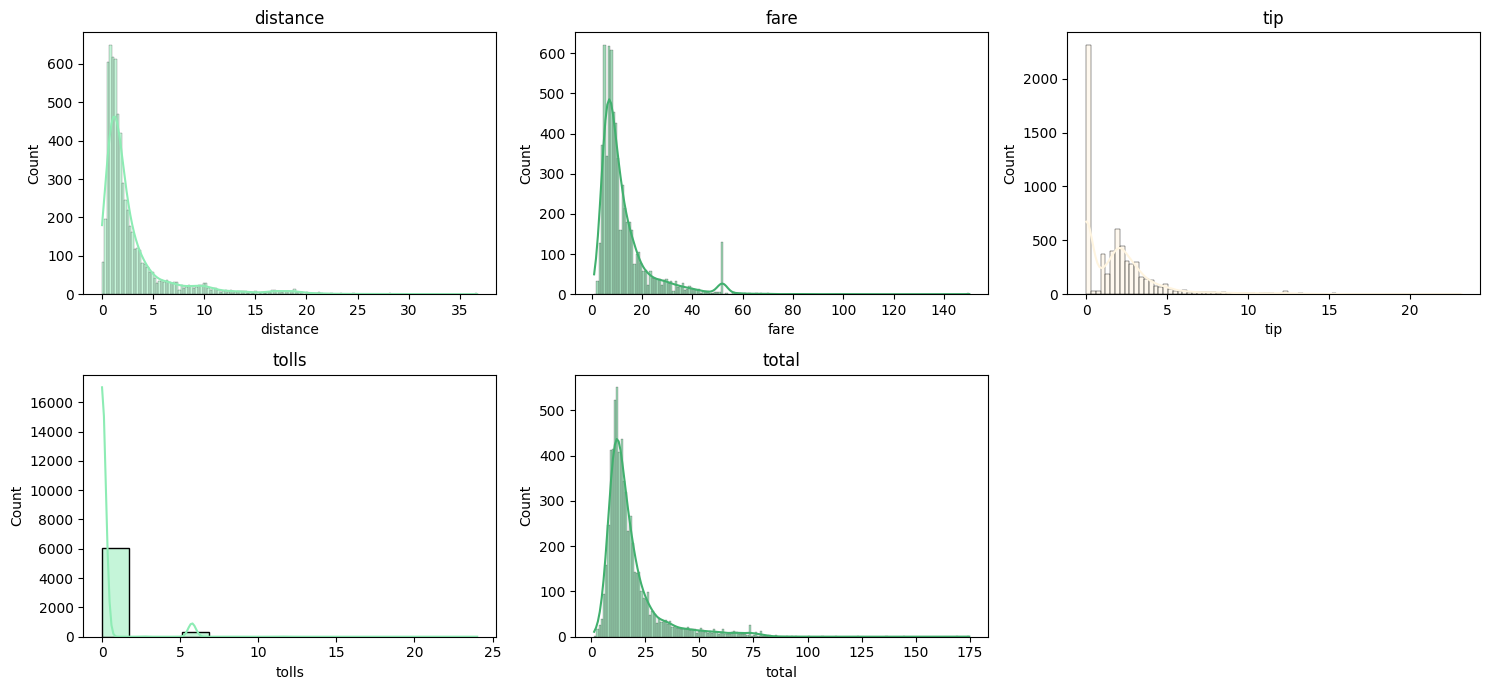

In [ ]:
#Numerical cols to plot
cols_num = ['distance','fare','tip','tolls','total']

#set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,7))

#Flatten the axes array for easy iteration :
#converts the 2D array of axes (which refers to individual subplots) into a 1D array.
#This makes it easier to loop over each subplot.
axes = axes.flatten()

#plot each numerical column
for i, col in enumerate(cols_num):
  ax=axes[i]
  sns.histplot(taxis[col], ax=ax, kde=True, color=palette[i % len(palette)])
  ax.set_title(col)

#remove any remaining empty subplots
for i in range(len(cols_num), len(axes)):
  fig.delaxes(axes[i])

#Adjust layout to prevent overlapping titles
plt.tight_layout()

plt.show()


# creating histograms for 5 numerical columns from the taxis dataset (distance, fare, tip, tolls, total).
# These histograms will be displayed in a grid of subplots (2 rows, 3 columns).
# After plotting the histograms, the extra subplot (the 6th one) is removed for a clean look, and the layout is adjusted for better readability


We can see from the Histograms that **All variables are left skewed and are not distributed normally.** We will be using advance methods to handle this.

#Normalization

- Using methods like **PowerTransformer or QuantileTransformer** to handle this issue and try to get Gaussian like shape.

In [ ]:
taxis.head(5)

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_borough,dropoff_borough,pickup_zone_tfidf_0,pickup_zone_tfidf_1,pickup_zone_tfidf_2,pickup_zone_tfidf_3,pickup_zone_tfidf_4,dropoff_zone_tfidf_0,dropoff_zone_tfidf_1,dropoff_zone_tfidf_2,dropoff_zone_tfidf_3,dropoff_zone_tfidf_4
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,1,1,2,2,0.143998,-0.247534,-0.212591,0.408423,-0.189428,0.171046,-0.006463,-0.094485,0.140508,0.003661
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,1,0,2,2,0.569516,-0.432575,-0.479467,-0.290769,0.009442,0.594314,-0.374437,-0.108350,0.494384,0.073917
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,1,1,2,2,0.000016,-0.000022,0.000082,-0.000062,-0.000065,0.250115,-0.329899,0.308567,0.261524,0.623197
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,1,1,2,2,0.014272,-0.059034,-0.160256,0.190831,0.325654,0.153011,-0.246522,0.209275,0.297849,0.274358
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,1,1,2,2,0.650534,0.583198,0.144620,0.205373,0.056755,0.153011,-0.246522,0.209275,0.297849,0.274358


In [ ]:
#Intialize Power Transformer
pt = PowerTransformer(standardize=True, method='yeo-johnson')

#numerical coluns to transform
cols_num_pt = ['tip','tolls']

#fit & transform
for col in cols_num_pt:
  taxis[col]=pt.fit_transform(taxis[[col]])

#Intialize Quantile transformer
qt = QuantileTransformer(output_distribution='normal')

#numerical columns to transform
cols_num = ['distance','fare','total']

#fit & transform
for col in cols_num:
  taxis[col]=qt.fit_transform(taxis[[col]])

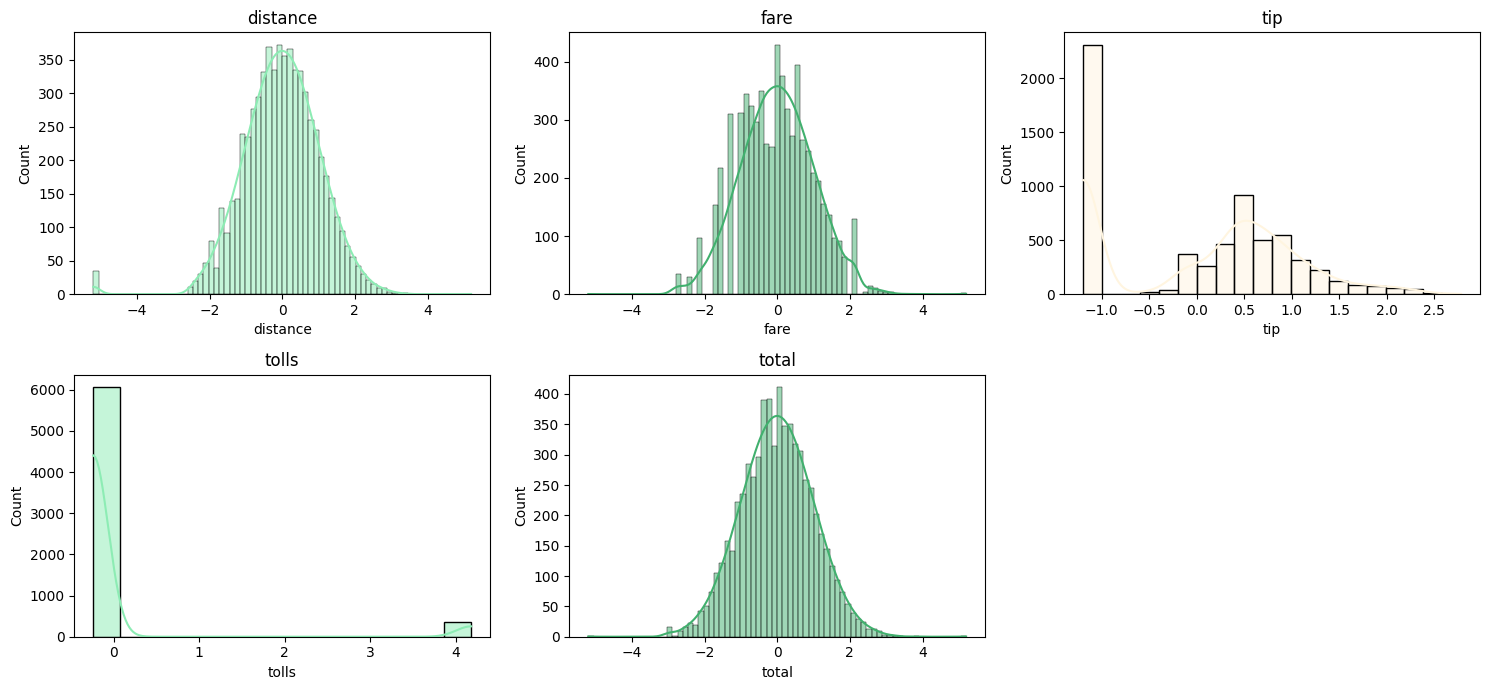

In [ ]:
#Numerical coluns to plot

cols_num = ['distance','fare','tip','tolls','total']

#set up the fig and axes for subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,7))

#flatten the axes
axes=axes.flatten()

#Plot each numerical columns:
for i, col in enumerate(cols_num):
  ax=axes[i]
  sns.histplot(taxis[col], ax=ax, kde=True, color=palette[i % len(palette)])
  ax.set_title(col)

#remove the remaining empty subplot
for i in range(len(cols_num), len(axes)):
  fig.delaxes(axes[i])

#adjust the layout to prevent overlapping titles
plt.tight_layout()

plt.show()

#**Model Building**

In [ ]:
#X and y
X = taxis.drop(['payment', 'pickup','dropoff'], axis=1)
y = taxis['payment']

#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

,passengers,distance,fare,tip,tolls,total,color,pickup_borough,dropoff_borough,pickup_zone_tfidf_0,pickup_zone_tfidf_1,pickup_zone_tfidf_2,pickup_zone_tfidf_3,pickup_zone_tfidf_4,dropoff_zone_tfidf_0,dropoff_zone_tfidf_1,dropoff_zone_tfidf_2,dropoff_zone_tfidf_3,dropoff_zone_tfidf_4
748,2,0.037646,0.119468,-1.194886,-0.239292,0.032625,1,2,2,3.313036e-02,-6.060751e-02,-0.009273,0.212097,-0.107286,0.191988,-0.238414,0.267428,0.111297,0.273957
5720,1,-0.437620,-0.364191,-1.194886,-0.239292,-1.387908,0,2,2,5.124936e-01,-8.029676e-02,0.171099,-0.183440,0.131719,0.489928,0.026049,-0.070278,-0.246291,0.024154
1310,2,0.403356,0.326900,0.829402,-0.239292,0.493553,1,2,2,-8.944106e-08,3.547515e-07,-0.000003,0.000011,-0.000024,0.006091,-0.029151,0.034092,0.091491,0.087917
5343,1,0.315012,0.326900,0.832544,-0.239292,0.507774,1,2,2,3.313036e-02,-6.060751e-02,-0.009273,0.212097,-0.107286,0.000043,-0.000027,0.000006,-0.000222,-0.000600
1480,1,0.503497,0.548158,-1.194886,-0.239292,0.330873,1,2,2,1.658946e-01,-2.168272e-01,-0.026197,0.345683,-0.002540,0.419789,0.561195,0.058932,0.331423,0.086542


#**1) LightGBM**

 LightGBM (Light Gradient Boosting Machine) is a powerful machine learning algorithm that is especially good for large datasets and high-dimensional data. It works by building a series of decision trees, where each tree tries to correct the errors made by the previous ones.

LightGBM starts by creating a decision tree. A decision tree is a flowchart-like structure where each node represents a decision based on a feature (like distance or passengers), and each branch represents the outcome of that decision.

- Making Predictions with the First Tree:

The first decision tree makes predictions on the total amount paid (total). For example, it might decide that rides with a distance greater than 5 miles will likely have a total amount above $20.
This tree will not be perfect. There will be errors in its predictions.

- Building the Next Tree:

 LightGBM then builds the next tree, but this tree focuses on correcting the errors made by the first tree. For example, if the first tree underestimated the total amount for rides with a high tip, the second tree might adjust for that.
This process is called gradient boosting, where each new tree is added to improve the model's performance by focusing on the mistakes of the previous trees.

- Continue Building Trees:

LightGBM keeps adding trees, with each one focusing on correcting the errors of the combined predictions of all previous trees. This process continues until a predefined number of trees is built or the model achieves a certain level of accuracy.

- Making Final Predictions:

The final prediction for the total amount is the combined prediction of all the trees. LightGBM combines these predictions by adding up the contributions of each tree (each tree’s output is weighted and summed).


**Why LightGBM Is Fast**

1) Leaf-Wise Growth: Unlike some other boosting algorithms that grow trees level by level (making the tree balanced), LightGBM grows trees leaf-wise (it splits the leaf that reduces the error the most). This approach makes LightGBM faster and more efficient, especially with large datasets.

2) Histogram-Based: LightGBM uses a histogram-based technique for finding the best split point, which significantly speeds up the computation.

**Code working**

L_BASE = lgb.LGBMClassifier(**lgb_params)

**V_CV = cross_val_score(L_BASE, X_T, y_T, scoring ='roc_auc', cv=10, n_jobs=-1)**

- Using Cross validation, we evaluate the performance of LightGBM classifier(L_BASE) on training data(X_T, y_T) using ROC AUC as the scoring metric. We perform 10-fold cross-validation (cv=10) and utilize all available CPU cores (n_jobs = -1)

In [ ]:
#Params of LGB Classifier

lgb_params = {
    'n_estimators' : 1000,
    'learning_rate' : 0.05,
    'max_depth': 6,
    'reg_alpha' : 0.1,
    'reg_lambda' : 0.1,
    'num_leaves' : 50,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity' : -1
}


# Train LGB Classifier
L_BASE = lgb.LGBMClassifier(**lgb_params)
V_CV = cross_val_score(L_BASE, X, y, scoring = 'roc_auc', cv=10, n_jobs=-1)

print(f'The average ROC AUC of LGB Classifier is {V_CV.mean()}')

The average ROC AUC of LGB Classifier is 0.9734838507559855


#**2) CatBoost**

**CatBoost** (short for Categorical Boosting) is a powerful and efficient gradient boosting algorithm designed to handle categorical features without the need for extensive preprocessing, like one-hot encoding or label encoding, which other algorithms often require.

**Key Features of CatBoost:**
- **Handles Categorical Variables Automatically**: CatBoost is designed to deal with categorical data directly. You can feed the algorithm raw categorical columns (like "pickup_zone" or "color") without needing to encode them manually.
- **Avoids Overfitting:** CatBoost prevents overfitting on small datasets, which can sometimes happen with other boosting algorithms.
- **Efficient with Imbalanced Data:** It works well with datasets where one class is much more frequent than another.
- **Fast and Accurate:** optimized for both training speed and prediction accuracy, even on large datasets.


***CatBoost builds a sequence of decision trees, where each tree tries to correct the mistakes made by the previous one. However, it has a few improvements, especially in how it handles categorical features and overfitting.***

In [ ]:
#Params CAT Classifier
cat_params = {
    'n_estimators' : 853,
    'learning_rate' : 0.10899577626375372,
    'depth' : 7,
    'subsample' : 0.998357427917925,
    'colsample_bylevel' : 0.7340962061535496,
    'random_strength' : 6.262882561405091,
    'min_data_in_leaf' : 92,
    'verbose': 0
}

#train CAT Classifier
C_BASE = CatBoostClassifier(**cat_params)
C_CV = cross_val_score(C_BASE, X, y, scoring ='roc_auc', cv=5, n_jobs=-1)

print(f'The average ROC AUC of CATBoost Classifier is : {C_CV.mean()}')

The average ROC AUC of CAT Classifier is : 0.9703279559477114


# **3)RandomForest**

A Decision Forest is an ensemble method, which means it builds multiple models (decision trees in this case) and combines them to improve the accuracy and stability of predictions. It is often used in classification and regression tasks.

**Key Features of Decision Forest:**
- **Multiple Decision Trees:** It builds several decision trees, each trained on random subsets of the data.
- **Voting System:** For classification tasks, it combines the results of these trees by a majority vote.
- **Averaging for Regression:** For regression tasks, it averages the predictions of all trees.
- **Improves Accuracy**: By combining multiple trees, it reduces overfitting and improves accuracy.




#How Random Forest (Decision Forest) Works:
**1) Bootstrapping (Bagging):**

Random Forest uses a technique called bootstrapping, where it creates random subsets of the data to train each decision tree. Each subset contains different samples and features.
By training on multiple subsets, each tree gets a slightly different view of the data.

**2) Building Decision Trees:**

Each decision tree is built by splitting the data based on features. For example, one tree might split the data based on the "distance" feature, while another tree might split the data based on the "pickup_zone" feature.
The tree continues splitting until it groups the data into small groups where the target is mostly the same (e.g., fares above 20 are grouped together).

**3) Voting:**

After all the trees are built, each tree gives a prediction. In classification tasks, the final prediction is based on the majority vote.

**4) Reduces Overfitting:**

Since Random Forest uses many trees and random subsets of data, it reduces overfitting.

In [ ]:
#params of RandomForest Classifier

rf_params = {
    'n_estimators' : 100,
    'max_depth' : 10,
    'min_samples_split' : 5,
    'min_samples_leaf' : 2,
    'max_features' : 'sqrt',
    'random_state' : 42
}

#train RandomForest Classifier

rf_base = RandomForestClassifier(**rf_params)
rf_cv = cross_val_score(rf_base, X, y, scoring = 'roc_auc', cv=5, n_jobs =-1)


print(f'The average ROC AUC of RandomForest Classifier is :{rf_cv.mean()}')

The average ROC AUC of RandomForest Classifier is :0.9710013725060067


It seems Light GBM has scored better than other 2 classifiers in this dataset.